In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal

In [13]:
class simulated():
    def __init__(self, t_max, n, k1, k2, t0):
        self.t_max = t_max
        self.n = n # length of light curve
        self.k1 = k1
        self.k2 = k2
        self.t0 = t0
        
    def piecewise_exponential(self, uid, k1, k2, t0):
        """
        k - steepness of rise
        t0 - length of rise
        TODO - add in a second decay constant 
        """
        t = np.linspace(0, self.t_max, self.n)
        mask = t<t0
        N1 = (np.exp(k1*t0)-1)/k1 - t0 # integral of y1 from 0 to t0
        N2 = np.exp(-k2*t0)/k2 * np.exp(k2*t0) * ( np.exp(k1*t0) - 1 ) # integral of N2 from t0 to inf
        norm = N1 + N2 # Total normalisation factor
        y1 = np.exp(k1*t[mask])-1
        y2 = np.exp(k2*t0) * ( np.exp(k1*t0)-1 ) * np.exp(-k2*t[~mask])
        noise = np.random.normal(0, 0.2, self.n)
        unnormed = np.concatenate((y1, y2))
        mag = unnormed/norm + noise
        return pd.DataFrame(data={'uid': uid, 'mjd':t, 'mag':mag, 'magerr':0.01, 'catalogue':0})

        
    def generate_lcs(self, n_obj):
        df = pd.DataFrame(columns=['uid', 'mjd', 'mag', 'magerr', 'catalogue'])
        k1 = np.random.normal(self.k1, 0.2, size=n_obj)
        k2 = np.random.normal(self.k2, 0.1, size=n_obj)
        t0 = np.random.normal(self.t0, 0.1, size=n_obj)
        for i in range(n_obj):
            df = df.append(self.piecewise_exponential(i, k1[i], k2[i], t0[i]), ignore_index=True)
        
        self.df = df.set_index('uid')
    
    def calculate_dtdm(self, uids):
        """
        Save (∆t, ∆m) pairs from lightcurves. 

        Parameters
        ----------
        uids : array_like
            uids of objects to be used for calcuation
        time_key : str
            either mjd or mjd_rf for regular and rest frame respectively
        Returns
        -------
        df : DataFrame
            DataFrame(columns=[self.ID, 'dt', 'dm', 'de', 'dm2_de2', 'cat'])
        """
        sub_df = self.df[['mjd', 'mag', 'magerr', 'catalogue']].loc[uids]
        dtdms = pd.DataFrame(columns=['uid', 'dt', 'dm', 'de', 'dm2_de2', 'cat'])
        for uid, group in sub_df.groupby('uid'):
            #maybe groupby then iterrows? faster?
            mjd_mag = group[['mjd','mag']].values
            magerr = group['magerr'].values
            cat	 = group['catalogue'].values
            n = len(mjd_mag)
            # dtdm defined as: ∆m = (m2 - m1), ∆t = (t2 - t1) where (t1, m1) is the first obs and (t2, m2) is the second obs.
            # Thus a negative ∆m corresponds to a brightening of the object
            unique_pair_indicies = np.triu_indices(n,1)

            dcat = cat*cat[:,np.newaxis]
            dcat = dcat[unique_pair_indicies]

            dtdm = mjd_mag - mjd_mag[:,np.newaxis,:]
            dtdm = dtdm[unique_pair_indicies]
            dtdm = dtdm*np.sign(dtdm[:,0])[:,np.newaxis]

            dmagerr = ( magerr**2 + magerr[:,np.newaxis]**2 )**0.5
            dmagerr = dmagerr[unique_pair_indicies]

            dm2_de2 = dtdm[:,1]**2 - dmagerr**2

            duid = np.full(int(n*(n-1)/2),uid,dtype='uint32')

            # collate data to DataFrame and append
            dtdms = dtdms.append(pd.DataFrame(data={'uid':duid,'dt':dtdm[:,0],'dm':dtdm[:,1], 'de':dmagerr, 'dm2_de2':dm2_de2, 'cat':dcat}))
            
            self.dtdms = dtdms
        
    def plot_series(self, uids, survey=None, axes=None, **kwargs):
        """
        Plot lightcurve of given objects

        Parameters
        ----------
        uids : array_like
                uids of objects to plot
        catalogue : int
                Only plot data from given survey
        survey : 1 = SSS_r1, 3 = SSS_r2, 5 = SDSS, 7 = PS1, 11 = ZTF

        """
        if axes is None:
            fig, axes = plt.subplots(len(uids),1,figsize = (25,3*len(uids)), sharex=True)
        if len(uids)==1:
            axes=[axes]

        for uid, ax in zip(uids,axes):
            x = self.df.loc[uid].sort_values('mjd') #single obj
#             ax.errorbar(x['mjd'], x['mag'], yerr = x['magerr'], lw = 1, **kwargs)
            ax.plot(x['mjd'], x['mag'], lw = 1, **kwargs)
#             ax.invert_yaxis()
            ax.set(xlabel='mjd', ylabel='mag')
            ax.text(0.02, 0.9, 'uid: {}'.format(uid), transform=ax.transAxes, fontsize=10)

        plt.subplots_adjust(hspace=0)

        if axes is not None:
            return fig, axes

    def calculate_sf(self):
        sf = []
        mjd_edges = np.linspace(0,self.t_max,21)
        mjd_centres = (mjd_edges[:-1] + mjd_edges[1:])/2
        for mjd_lower, mjd_upper in zip(mjd_edges[:-1], mjd_edges[1:]):
            subdf = self.dtdms[(mjd_lower < self.dtdms['dt']) & (self.dtdms['dt'] < mjd_upper)]
            n = len(subdf)
            sf.append( ( (subdf['dm']**2).sum()/n )**0.5 )
        return mjd_centres, sf
    
    def calculate_sf_asym(self):
        sf_p = []
        sf_n = []
        mjd_edges = np.linspace(0,self.t_max,21)
        mjd_centres = (mjd_edges[:-1] + mjd_edges[1:])/2
        for mjd_lower, mjd_upper in zip(mjd_edges[:-1], mjd_edges[1:]):
            subdf = self.dtdms[(mjd_lower < self.dtdms['dt']) & (self.dtdms['dt'] < mjd_upper)]
            n = len(subdf)
            sf_p.append( ( (subdf['dm'][subdf['dm']>0]**2).sum()/n )**0.5 )
            sf_n.append( ( (subdf['dm'][subdf['dm']<0]**2).sum()/n )**0.5 )
        return mjd_centres, sf_p, sf_n

In [14]:
n_obj = 50
gl_frsd = simulated(10, 200, 3, 0.5, 1)
gl_frsd.generate_lcs(n_obj)
gl_frsd.calculate_dtdm(range(n_obj))

gl_srfd = simulated(10, 200, 0.5, 3, 8)
gl_srfd.generate_lcs(n_obj)
gl_srfd.calculate_dtdm(range(n_obj))

### asym

[Text(0.5, 0, '∆t'), Text(0, 0.5, 'SF')]

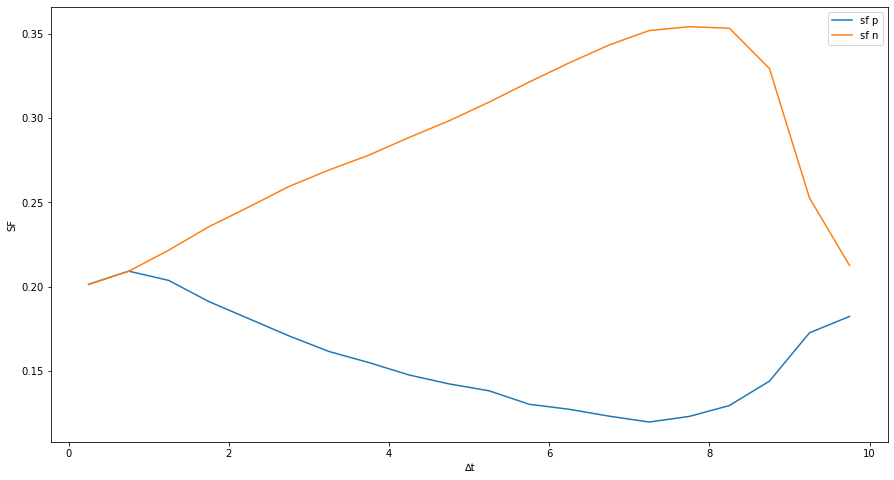

In [15]:
mjd_centres, sf_p, sf_n = gl_frsd.calculate_sf_asym()
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.plot(mjd_centres, sf_p, label = 'sf p')
ax.plot(mjd_centres, sf_n, label = 'sf n')
ax.legend()
ax.set(xlabel='∆t', ylabel='SF')

[Text(0.5, 0, '∆t'), Text(0, 0.5, 'SF')]

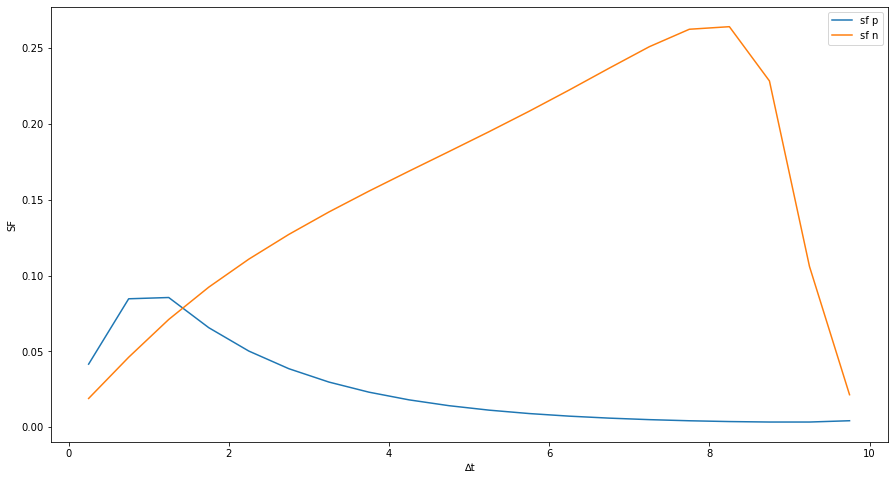

In [6]:
mjd_centres, sf_p, sf_n = gl_frsd.calculate_sf_asym()
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.plot(mjd_centres, sf_p, label = 'sf p')
ax.plot(mjd_centres, sf_n, label = 'sf n')
ax.legend()
ax.set(xlabel='∆t', ylabel='SF')

### Comparing fast rise slow decent with slow rise fast decent

[Text(0.5, 0, '∆t'), Text(0, 0.5, 'SF')]

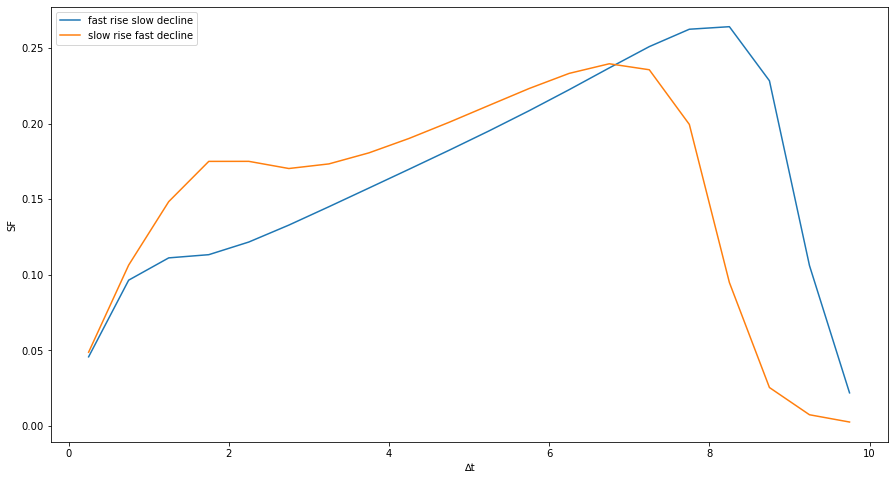

In [7]:
mjd_centres1, sf1 = gl_frsd.calculate_sf()
mjd_centres2, sf2 = gl_srfd.calculate_sf()
fig, ax = plt.subplots(1,1, figsize=(15,8))
ax.plot(mjd_centres1, sf1, label = 'fast rise slow decline')
ax.plot(mjd_centres2, sf2, label = 'slow rise fast decline')
ax.legend()
ax.set(xlabel='∆t', ylabel='SF')